<h2><center><font color=#D40004><u> RAG-for-PDF-question-answering </u></font></center></h2>
<br>

<div style="padding: 40px; background: linear-gradient(135deg, #f5f7fa, #cdd2d8); border: 3px groove #d1d8e0; border-radius: 30px; box-shadow: 0 10px 25px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <h2 style="color: #2c3e50; font-size: 150%; border-bottom: 3px solid #3498db; display: inline-block; padding-bottom: 10px; margin-bottom: 20px;">
        Project Objectif</h2>
    <p>This project aims to explore the Retrieval-Augmented Generation (RAG) concept through a comprehensive notebook. We will cover the following steps:

1. **Reading PDF Files**: Import and read PDF files.
2. **Chunking**: Break down the PDF content into manageable chunks.
3. **Embedding and Storing**: Embed the PDF content and store it in a vector store.
4. **Retrieval Phase**: Embed user questions, extract relevant documents, and generate responses using the Cohere model.

By following this process, we will build a system capable of answering detailed questions about the content of PDF documents.
</div>

# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:center; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'></span></b> <b>Table of Content</b></div>

* [1. Loading and Importing Libraries](#1)
* [2. Load PDF and Chunking](#2)
* [3. Building the Vector Database](#3)
* [4. Search the Closest Documents to the Query](#4)
* [5. Generate Answers](#5)


<a id='1'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>1 |</span></b> <b>Loading and Importing Libraries</b></div>

In [47]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [48]:
!pip install pdfplumber
!pip install langchain_cohere
!pip install  langchain_core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt
import pdfplumber
pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

<a id='2'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>2 |</span></b> <b>Load PDF and Chunking</b></div>


In [ ]:
# load the pdf using pdfplumber and store it content in langchain documents
liste_pages_content=[]
with pdfplumber.open("/kaggle/input/labipdf/la bi.pdf") as pdf: # put your pdf path
    for i in range( len(pdf.pages)):
        page_content = pdf.pages[i].extract_text()
        metadata={"source": "la bi.pdf", "page": i}
        document = Document(
            page_content=page_content,
            metadata=metadata
        )
        liste_pages_content.append(document)

In [52]:
# chunk the documents using RecursiveCharacterTextSplitter offerd by langchain
# We use a hierarchical list of separators specifically tailored for splitting text documents

MARKDOWN_SEPARATORS = [
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in liste_pages_content:
    docs_processed += text_splitter.split_documents([doc])

In [58]:
# for embedding we are going to useall-mpnet-base-v2 from hugging face , before embedding we need to make sure that the length
# of the documents is less than the length of sequece token taken by the model.

print(f"Model's maximum sequence length: {SentenceTransformer('sentence-transformers/all-mpnet-base-v2').max_seq_length}")
tokenizer=AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
list= [len(tokenizer.encode(doc.page_content)) for doc in docs_processed]

print('the largest input doc is with a length of d:',  max(list))

Model's maximum sequence length: 384
the largest input doc is with a length of d: 218


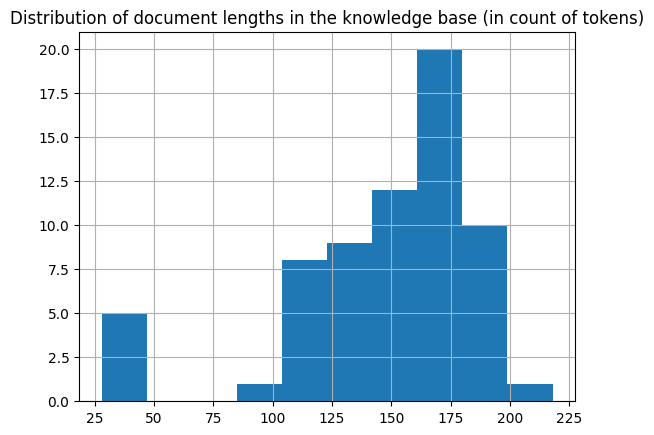

In [59]:
# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(list).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

➡️ there is no probleme in the length of sequences 

➡️ Chunk length distribution looks good!

##  Building the vector database

<a id='3'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>3 |</span></b> <b> Building the Vector Database</b></div>

In [62]:
EMBEDDING_MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)
# store the embeddings in faiss db
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

langchain_community.vectorstores.faiss.FAISS

In [65]:
# Embed a user query in the same space
user_query = "what are the benefits of business intelligence?"
query_vector = embedding_model.embed_query(user_query)

In [83]:
#To visualize the search for the closest documents, let’s project our embeddings from 768 dimensions down to 2 dimensions using PaCMAP.

import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)
embeddings_2d = [
    (KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))]+ [query_vector]
# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/opt/conda/lib/python3.10/site-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [94]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[0],
            "extract": docs_processed[i].page_content[:50] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

➡️ On the graph above, you can see a spatial representation of the knowledge base documents. As the vector embeddings represent the document’s meaning, their closeness in meaning should be reflected in their embedding’s closeness. 

➡️ The user query’s embedding is also shown: we want to find the k documents that have the closest meaning, thus we pick the k closest vectors.

## search  the closest docs to the query


<a id='4'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>4 |</span></b> <b>Search the Closest Documents to the Query</b></div>

In [1]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)



Starting retrieval for user_query='what are the benefits of business intelligence'...

==================================Top document==================================
Collaboration and Self-Service: Collaboration and self-service capabilities enable
users to explore and analyze data independently. Self-service BI tools allow users,
including non-technical users, to access and analyze data using intuitive interfaces
and predefined templates. Collaboration features promote knowledge sharing, data
discovery, and collaborative decision-making within the organization.
These key components work together to provide a comprehensive BI solution that
empowers organizations to leverage data for decision-making, gain insights, and
drive business success. Each component plays a crucial role in the overall BI
ecosystem, contributing to the effectiveness and value of the BI implementation.
Benefits of Business Intelligence
Business Intelligence (BI) offers numerous benefits to organizations across 

## Reader LLM

<a id='5'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>5 |</span></b> <b>Generate Answers</b></div>

In [ ]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

In [105]:
context

"\nExtracted documents:\nDocument 0:::\nCollaboration and Self-Service: Collaboration and self-service capabilities enable\nusers to explore and analyze data independently. Self-service BI tools allow users,\nincluding non-technical users, to access and analyze data using intuitive interfaces\nand predefined templates. Collaboration features promote knowledge sharing, data\ndiscovery, and collaborative decision-making within the organization.\nThese key components work together to provide a comprehensive BI solution that\nempowers organizations to leverage data for decision-making, gain insights, and\ndrive business success. Each component plays a crucial role in the overall BI\necosystem, contributing to the effectiveness and value of the BI implementation.\nBenefits of Business Intelligence\nBusiness Intelligence (BI) offers numerous benefits to organizations across various\nindustries. Here are some key benefits of implementing BI:\nData-Driven Decision Making: BI enables organizati

In [113]:
# initiat the llm model to generate answers following the given context
import cohere

co = cohere.Client("your_cohere_key")

response = co.chat(
    chat_history=[
        {"role": "USER", "message": """Using the information contained in the context,
        give a comprehensive answer to the question.
        Respond only to the question asked, response should be concise and relevant to the question.
        Provide the number of the source document when relevant.
        If the answer cannot be deduced from the context, do not give an answer."""}, 
        {
            "role": "CHATBOT",
            "message": """ Please provid the question and the context.""",
        },
    ],
    message=f"Question:\n{user_query}\Context:{context}\nResponse:\n",
    # perform web search before answering the question. You can also use your own custom connector.
    #connectors=[{"id": "web-search"}],
)

print(response.text)

Business Intelligence (BI) offers numerous benefits to organizations, including data-driven decision-making, competitive advantage, enhanced customer understanding, real-time reporting, and continuous improvement. BI enables organizations to gain insights, make informed and evidence-based decisions, identify opportunities and potential risks, and differentiate themselves in the market. It empowers organizations to analyze customer behavior, market trends, and competitive activities, leading to improved customer satisfaction, loyalty, and retention. Additionally, BI provides real-time, visually appealing reports and dashboards, ensuring stakeholders have up-to-date information for monitoring business performance.



<br>

<div style="padding: 40px; background: linear-gradient(135deg, #f5f7fa, #cdd2d8); border: 3px groove #d1d8e0; border-radius: 30px; box-shadow: 0 10px 25px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <h2 style="color: #2c3e50; font-size: 150%; border-bottom: 3px solid #3498db; display: inline-block; padding-bottom: 10px; margin-bottom: 20px;">
         More info</h2>
    <p> <a href="https://huggingface.co/learn/cookbook/advanced_rag">https://huggingface.co/learn/cookbook/advanced_rag</a>
</div>